# Health Data Set Analysis

The data set includes numerous factors for health.


<div class="alert alert-warning">

* need to include more info and links to where dataset comes from

    
* only include modules in import section that you use in the notebook - here you had `numpy` and `math` imported but they aren't used
    
    
* looks like there are a lot of other potentially interesting variables in the dataset related to health that could be explored as well
 
    
* I am not sure that inverting the health variables when they are proportions makes them easier to understand and communicate.
    

* There are state summary rows along with county level in these data - see comments and suggestion to drop the state/national rows.
    
</div>

In [65]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
# use relative file path and keep imports in one cell
# because a large data file you can follow warning suggestion
# and turn off low mem in load

health_df_raw = pd.read_csv("../data/county_health.csv", 
                            low_memory=False)

# Step 1

## Data Frame Examination

In [29]:
nrows, ncols, = health_df_raw.shape
print(f"There are {nrows} rows and {ncols} columns in the data frame.")

There are 3195 rows and 786 columns in the data frame.


* Each row represents the data for one county for the year 2020. 
* There are over 700 columns of data but many columns show different forms of data 
* The data frame comes from the 2020 data at https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation. 

In [30]:
list(health_df_raw)

['State FIPS Code',
 'County FIPS Code',
 '5-digit FIPS Code',
 'State Abbreviation',
 'Name',
 'Release Year',
 'County Ranked (Yes=1/No=0)',
 'Premature death raw value',
 'Premature death numerator',
 'Premature death denominator',
 'Premature death CI low',
 'Premature death CI high',
 'Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (AIAN)',
 'Premature death CI low (AIAN)',
 'Premature death CI high (AIAN)',
 'Premature death flag (AIAN) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Asian/Pacific Islander)',
 'Premature death CI low (Asian/Pacific Islander)',
 'Premature death CI high (Asian/Pacific Islander)',
 'Premature death flag (Asian/Pacific Islander) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Black)',
 'Premature death CI low (Black)',
 'Premature death CI high (Black)',
 'Premature death flag (Black) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Hispanic)',
 'Premature death CI low (Hispanic

The columns that we are concerned with are those that identify the specific county such as the state abbreviation, name, and FIPS code. For health data we shall look at the poor or fair health raw value which is an average measure of health, poor physical health days raw value which is a measure of physical health, poor mental health days raw value which is a measure of mental health, and life expectancy raw value which is life expectancy, columns.

In [31]:
columns = ['State FIPS Code', 'County FIPS Code', 
           '5-digit FIPS Code', 'State Abbreviation', 'Name', 
           'Poor or fair health raw value', 'Poor physical health days raw value', 'Poor mental health days raw value', 
           'Life expectancy raw value']

health_df = health_df_raw[columns]

In [32]:
health_df.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Life expectancy raw value
0,statecode,countycode,fipscode,state,county,v002_rawvalue,v036_rawvalue,v042_rawvalue,v147_rawvalue
1,0,0,0,US,United States,0.171986764,3.752828263,3.970320984,79.08913021
2,1,0,1000,AL,Alabama,0.220287029,4.918051715,4.939752942,75.41619415
3,1,1,1001,AL,Autauga County,0.208829873,4.743888867,4.654031397,76.87947717
4,1,3,1003,AL,Baldwin County,0.175091344,4.224519202,4.304056469,78.45025837


Row 0 of the data set describes the data, likely for internal use. So for our use we do not need it, and some columns can also be renamed to match python standards.

In [33]:
col_rename = {
    'State FIPS Code' : 'state_fips', 
    'County FIPS Code' : 'county_fips',
    '5-digit FIPS Code' : 'fips5', 
    'State Abbreviation' : 'state_abbreviation', 
    'Name' : 'name', 
    'Poor or fair health raw value' : 'poor_fair_health', 
    'Poor physical health days raw value' : 'poor_physical_days', 
    'Poor mental health days raw value' : 'poor_mental_days', 
    'Life expectancy raw value' : 'life_exp'
}

health_df = health_df.rename(columns = col_rename).drop(0)

In [34]:
health_df.head()

,state_fips,county_fips,fips5,state_abbreviation,name,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
1,0,0,0,US,United States,0.171986764,3.752828263,3.970320984,79.08913021
2,1,0,1000,AL,Alabama,0.220287029,4.918051715,4.939752942,75.41619415
3,1,1,1001,AL,Autauga County,0.208829873,4.743888867,4.654031397,76.87947717
4,1,3,1003,AL,Baldwin County,0.175091344,4.224519202,4.304056469,78.45025837
5,1,5,1005,AL,Barbour County,0.295918017,5.430278859,5.185594413,75.34193493


<div class="alert alert-warning">

* There seem to be three levels in these data:
   1. national
   2. state
   3. county
    

* These are reflected in the FIPS codes where 
   1. national = 0
   2. state is the thousands, e.g. AL = 1000
   3. county is hundreds down, e.g. Autauga County, AL = 1001, etc.
    
    
* So you need to take this into consideration in using these data - probably best to drop the rows from national and state and work with counties - or when working at state level use the state rows only (although this could be calculated from counties with groupby)
    
</div>

In [35]:
health_df['fips5'].astype(int).max()

56045

In [38]:
# example of just selecting US & state rows
state_fips = [str(n) for n in range(0,57000, 1000)]
state_filter = health_df['fips5'].isin(state_fips)
health_df_state = health_df[state_filter]
health_df_state

,state_fips,county_fips,fips5,state_abbreviation,name,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
1,0,0,0,US,United States,0.171986764,3.752828263,3.970320984,79.08913021
2,1,0,1000,AL,Alabama,0.220287029,4.918051715,4.939752942,75.41619415
70,2,0,2000,AK,Alaska,0.180801761,4.032359091,3.900052937,78.7721508
100,4,0,4000,AZ,Arizona,0.185550446,4.023226147,4.039216034,79.89649908
116,5,0,5000,AR,Arkansas,0.231986808,5.145336447,5.36385921,75.93061174
192,6,0,6000,CA,California,0.172182085,3.52517973,3.490155248,81.57580635
251,8,0,8000,CO,Colorado,0.14474017,3.448572895,3.847680429,80.5002804
316,9,0,9000,CT,Connecticut,0.138007098,3.287349493,3.470515946,80.86944868
325,10,0,10000,DE,Delaware,0.179946917,3.651560755,4.273029801,78.42865496
329,11,0,11000,DC,District of Columbia,0.130337937,2.885692334,3.562902972,78.5919757


<div class="alert alert-info">
    
* A better way to the numeric conversion on the columns of interest is to:
  1. make a list of the column names to convert
  2. apply the `pd.to_numeric` function to those columns
     ```
     health_df[numeric_cols].apply(pd.to_numeric)
     ```
  3. replace original column values with new converted values
    
    
* In general if you find yourself using a for loop to do a transform or calculation in `pandas` it is worth thinking about whether there is a more concise way to do it.
    
</div>

In [70]:
# 1. make a list of columns to convert to numeric type
numeric_cols = [
    'poor_fair_health', 'poor_physical_days', 
    'poor_mental_days', 'life_exp', "fips5"
]

# 2. apply the pd.to_numeric function to the values in these 
#    columns and replace the values
health_df[numeric_cols] = health_df[numeric_cols].apply(pd.to_numeric)

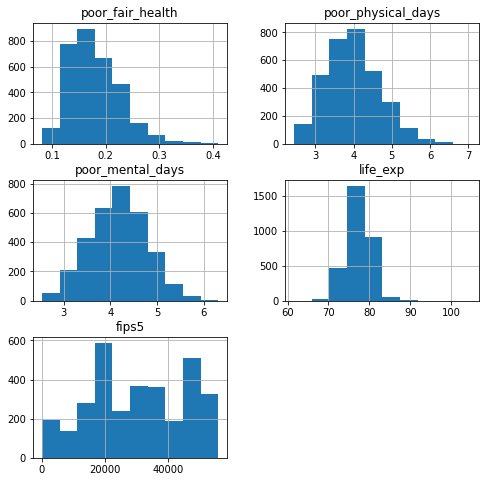

In [71]:
# look at distributions for the numeric variables
health_df[numeric_cols].hist(figsize=(8,8))
plt.show()

From the above graphs, the values for poor_mental_days roughly follow a normal distribution, and the ranges for poor_mental_days and poor_physical_days is roughly the same. However, the data values for poor_physical_days is slightly skewed right. The range on life expectancy is roughly 30 years, and has a distinct peak around 76 years old. Poor_fair_health is also skewed right. 

In [72]:
# basic descriptives
health_df[numeric_cols].describe().round(3)

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,fips5
count,3194.000,3194.000,3194.000,3121.000,3194.000
mean,0.179,3.989,4.166,77.486,30351.417
std,0.047,0.703,0.602,3.026,15179.046
min,0.081,2.449,2.533,61.626,0.000
25%,0.143,3.473,3.747,75.571,18171.500
50%,0.172,3.935,4.171,77.510,29174.000
75%,0.209,4.439,4.574,79.369,45074.500
max,0.410,7.062,6.314,104.740,56045.000


In [73]:
# which places have max and min values of the 4 variables?
health_df.set_index('name')[numeric_cols].aggregate(['idxmin', 'idxmax'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,fips5
idxmin,Douglas County,Carver County,Aleutians West Census Area,Buffalo County,United States
idxmax,Zavala County,Kusilvak Census Area,McDowell County,San Miguel County,Weston County


In [74]:
# checking whether taking mean of country rows grouped by state
# matches the equivalent row for the state

In [75]:
state_means_df=health_df[-state_filter].groupby('state_abbreviation')[numeric_cols].mean()

In [76]:
state_means_df.loc['AL']

poor_fair_health         0.238164
poor_physical_days       4.960199
poor_mental_days         4.966114
life_exp                74.644740
fips5                 1067.000000
Name: AL, dtype: float64

In [77]:
# row from original data frame for AL
health_df[health_df['fips5']=='1000'][numeric_cols]

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,fips5


<div class="alert alert-info">
    
* Hmm - kind of but not quite the same
    
* Seems like the best thing is to drop the national and state rows and work from the counties and create your own state level summaries
    
* You should adjust the code below
    
</div>

In [78]:
# Removed the negative change 
# use relative not absolute file paths
health_df.to_csv(r'../data/health_clean.csv', index = False)

In [79]:
health_df_state = health_df[-state_filter].groupby('state_abbreviation')[['poor_fair_health', 'poor_physical_days', 'poor_mental_days', 'life_exp']].mean()

In [80]:
health_df_state.head()

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
state_abbreviation,,,,
AK,0.169146,3.948983,3.610431,78.053287
AL,0.238164,4.960199,4.966114,74.644740
AR,0.233030,4.762518,4.763352,74.906292
AZ,0.198759,4.330210,4.357919,78.521663
CA,0.161861,3.744186,3.950604,80.308461


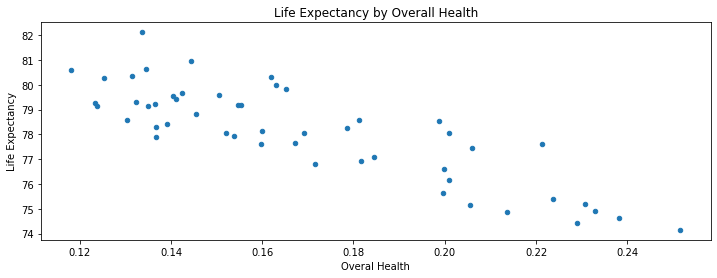

In [81]:
health_df_state.plot(kind='scatter', 
                     x = 'poor_fair_health', 
                     y = 'life_exp')
plt.xlabel("Overal Health")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by Overall Health")
plt.show()

In [82]:
# line graph makes no sense for these two variables
# you want a scatter plot

health_df_state[['poor_fair_health', 'life_exp']].corr()

# actually looks like quite a strong negative association


,poor_fair_health,life_exp
poor_fair_health,1.000000,-0.847811
life_exp,-0.847811,1.000000


There is a strong negative correlation between overall health and life expectancy. This is to be expected, as the greater the overal health value the worse average health is. Thus as life expectancy increases overall health also increases. Or equivanetly, as the proportion of the population who report poor health increases, the life expectancy in that state decreases.

<div class="alert alert-info">

* Can be useful to look at the max and min values and index values

</div>

In [83]:
health_df_state.abs().aggregate(['max', 'min'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
max,0.251581,5.328980,5.375160,82.115803
min,0.118176,2.885692,3.135525,74.146700


In [84]:
health_df_state.abs().aggregate(['idxmax', 'idxmin'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
idxmax,MS,WV,WV,HI
idxmin,CT,DC,SD,MS


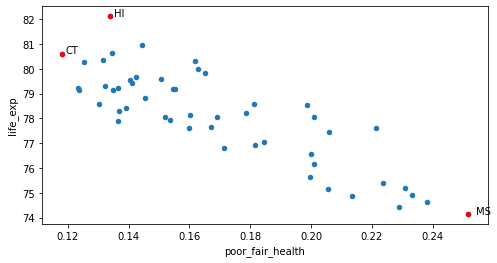

In [85]:
states_to_highlight = ['MS', 'CT', 'HI']

splot = health_df_state.abs().plot(kind='scatter', 
                     x = 'poor_fair_health', 
                     y = 'life_exp',
                     figsize=(8,4)
                                  )

highlights = health_df_state.abs().loc[states_to_highlight]


highlights.plot(kind='scatter',
                x = 'poor_fair_health', 
                y = 'life_exp',
                color='red',
                ax=splot
)

highlights.reset_index().apply(lambda r: plt.text(r['poor_fair_health']*1.01,
                                    r['life_exp'],
                                    r['state_abbreviation']
                                   ), axis=1)

plt.show()

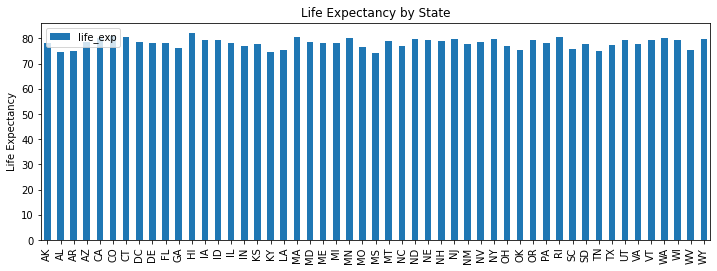

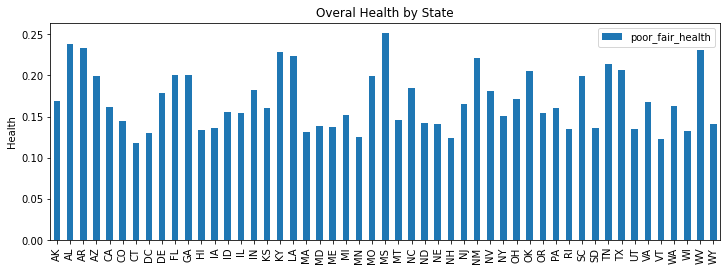

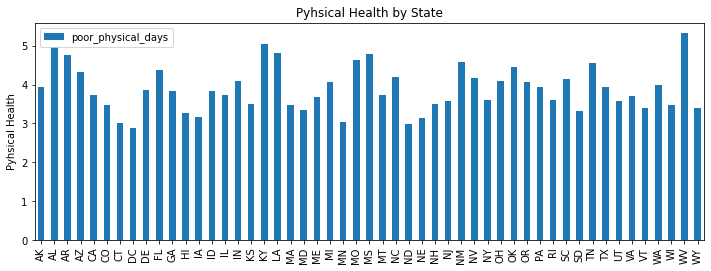

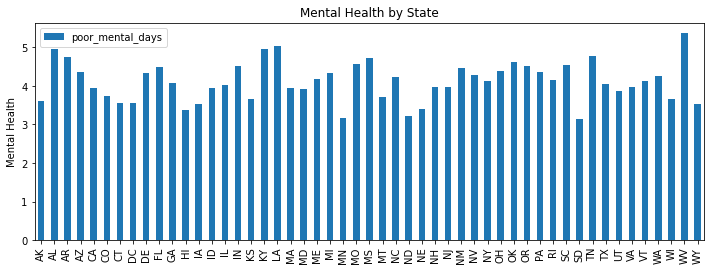

In [86]:
#plt.rcParams["figure.figsize"]=12,4

# can reset with
# plt.rcParams.setdefault("figure.figsize")

health_df_state.plot(kind='bar', 
                     y = 'life_exp',
                     figsize=(12,4)    # change the size of figure
                                       # on a plot basis not defaults
                    )

plt.xlabel("")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by State")
plt.xticks(rotation = 90)
plt.show()
health_df_state.plot(kind='bar', y = 'poor_fair_health')
plt.xlabel("")
plt.ylabel("Health")
plt.title("Overal Health by State")
plt.xticks(rotation = 90)
plt.show()
health_df_state.plot(kind='bar', y = 'poor_physical_days')
plt.xlabel("")
plt.ylabel("Pyhsical Health")
plt.title("Pyhsical Health by State")
plt.xticks(rotation = 90)
plt.show()
health_df_state.plot(kind='bar', y = 'poor_mental_days')
plt.xlabel("")
plt.ylabel("Mental Health")
plt.title("Mental Health by State")
plt.xticks(rotation = 90)
plt.show()

From the four plots above, overall life expectancy does not seem to differ much between states. However, overall health, mental health, and physical health have larger ranges. 

# Step 2

## Questions
* What is the relation between overall health, mental health, physical health, and life expectancy?
* Do any states stand out as having particually high/low health?

## Steps:
* Q1
    * Create a geoplot for all variables, and see if the geoplot shows any correlation.
    * Create a scatter plot comparing overal health to mental health, physical health, and life expectancy 
    * Look at the coorelation between the varaiables
    * Initially expect a positve relation between all measures except for life expactency, as all other measures are for bad health. 
* Q2
    * Group the data by state 
    * plot the measures in a bar chart
    * see if any one state stands out

### Geoplots

In [87]:
# source 
# https://github.com/deldersveld/topojson/tree/master/countries/united-states
us_map_gdf = gpd.read_file('../data/us_counties_albers.geojson')
us_map_gdf['fips']=us_map_gdf['fips'].astype(int)

In [89]:
health_gdf = pd.merge(us_map_gdf,
         health_df,
         left_on='fips',
         right_on='fips5'
        )

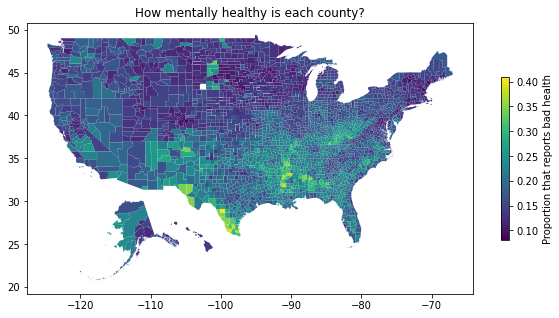

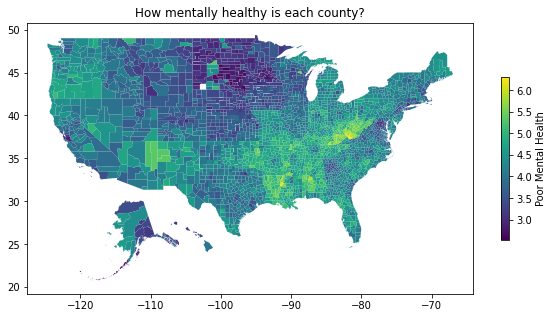

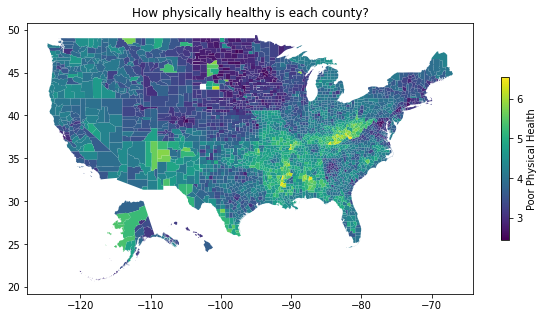

In [97]:
health_gdf.plot(column='poor_fair_health', 
                       legend=True,
                       figsize=(10,10),
                       legend_kwds={'shrink': 0.3,
                                    'label': 'Proportion that reports bad health'
                                   }
                      )

plt.title("How mentally healthy is each county?")
plt.show()

health_gdf.plot(column='poor_mental_days', 
                       legend=True,
                       figsize=(10,10),
                       legend_kwds={'shrink': 0.3,
                                    'label': 'Poor Mental Health'
                                   }
                      )

plt.title("How mentally healthy is each county?")
plt.show()

health_gdf.plot(column='poor_physical_days', 
                       legend=True,
                       figsize=(10,10),
                       legend_kwds={'shrink': 0.3,
                                    'label': 'Poor Physical Health'
                                   }
                      )

plt.title("How physically healthy is each county?")
plt.show()

From the geoplot it seems that overall the southern states have poorer health. Additioanlly the geoplots for mental and physical health look almost the same. This shows a high correlation between the two measures. 

### Question 1

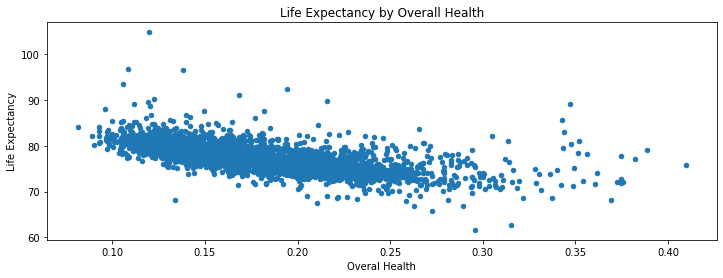

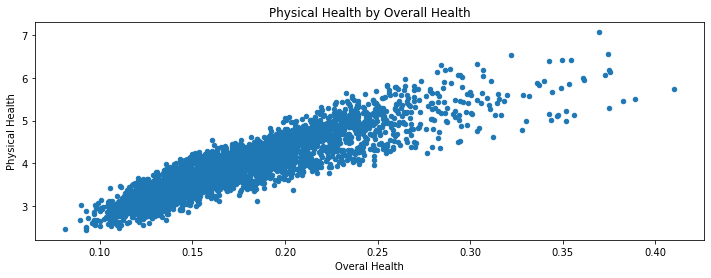

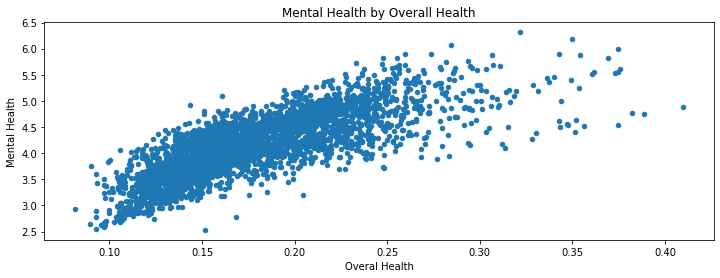

In [99]:
health_df[-state_filter].plot(kind='scatter', x = 'poor_fair_health', y = 'life_exp')
plt.xlabel("Overal Health")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by Overall Health")
plt.show()
health_df[-state_filter].plot(kind='scatter', x = 'poor_fair_health', y = 'poor_physical_days')
plt.xlabel("Overal Health")
plt.ylabel("Physical Health")
plt.title("Physical Health by Overall Health")
plt.show()
health_df[-state_filter].plot(kind='scatter', x = 'poor_fair_health', y = 'poor_mental_days')
plt.xlabel("Overal Health")
plt.ylabel("Mental Health")
plt.title("Mental Health by Overall Health")
plt.show()

In [100]:
health_df[['poor_fair_health', 'life_exp', 
           'poor_physical_days','poor_mental_days']].corr()

,poor_fair_health,life_exp,poor_physical_days,poor_mental_days
poor_fair_health,1.000000,-0.645189,0.891073,0.780832
life_exp,-0.645189,1.000000,-0.679527,-0.654201
poor_physical_days,0.891073,-0.679527,1.000000,0.933549
poor_mental_days,0.780832,-0.654201,0.933549,1.000000


#### Answer and Interpretation/Observation
The outcomes are as expected. Overall health has a strong positive correlation to mental and physical health, and a negative correlation to life expectancy. That is to say as overall health increases (numeric value decreaes), physical health, mental health, and life expectancy all increase as well. From the correlation table, physical and mental health share the highest correlation. This is expected and was apparent from the geoplots of mental and physical health. 

### Question 2

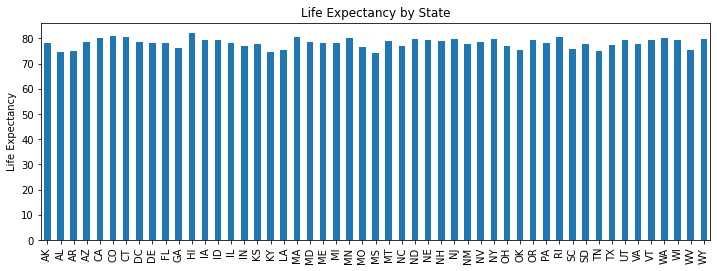

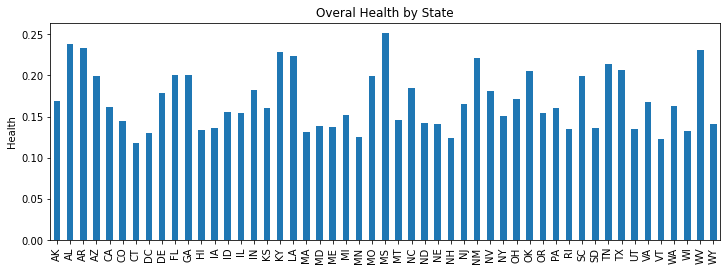

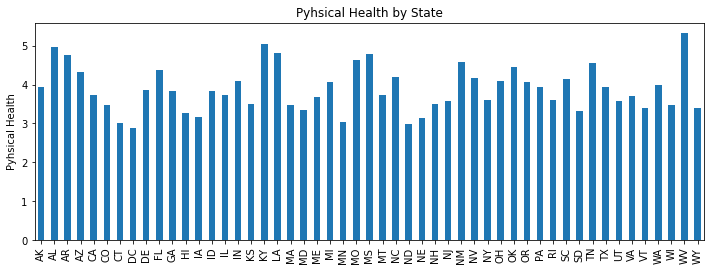

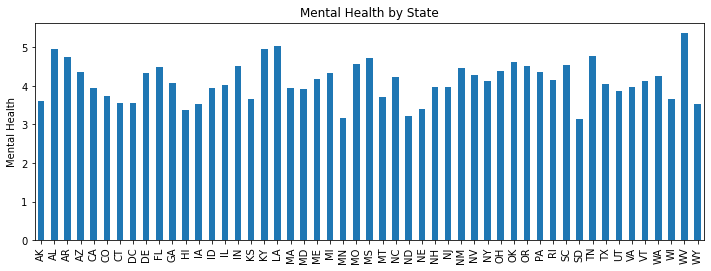

In [101]:
plt.rcParams["figure.figsize"]=12,4

health_df_state.plot(kind='bar', y = 'life_exp')

plt.xlabel("")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()
health_df_state.plot(kind='bar', y = 'poor_fair_health')
plt.xlabel("")
plt.ylabel("Health")
plt.title("Overal Health by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()
health_df_state.plot(kind='bar', y = 'poor_physical_days')
plt.xlabel("")
plt.ylabel("Pyhsical Health")
plt.title("Pyhsical Health by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()
health_df_state.plot(kind='bar', y = 'poor_mental_days')
plt.xlabel("")
plt.ylabel("Mental Health")
plt.title("Mental Health by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()

In [102]:
health_df_state.abs().aggregate(['max', 'min'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
max,0.251581,5.328980,5.375160,82.115803
min,0.118176,2.885692,3.135525,74.146700


In [103]:
health_df_state.abs().aggregate(['idxmax', 'idxmin'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
idxmax,MS,WV,WV,HI
idxmin,CT,DC,SD,MS


#### Answer and Interpretation/Observation
No state particually stands out in regards to life expectancy. However, West Virginia has the poorest average mental and physical health (it is not surprising that the same state has the poorest mental and physical health given the high correlation between the too seen in question 1). Additionally, Mississippi has the poorest overall health. Hawaii has the highest life expectancy at 82 years old, while Mississippi has the lowest life_expectancy and the lowest overall health. Connecticut has the best overall health. West Virginia has the worst physical and mental health. DC has the best physical health, and South Dakota has the best mental health. 